In [33]:
import collections
import random
import sys
import time

import simpy
from faker import Faker

In [34]:
NUM_BOLETO = 120
TIEMPO_SIMULACION = 120

In [35]:
acciones_globales = {}
acciones_individuales = {}
clientes = []
faker = Faker()


class Cliente:
    renegado: bool = False
    pelicula: str = 'NA'
    cantidad_boletos: int = 0
    acciones: dict = {}

    def __init__(self, nombre):
        self.nombre = nombre
        pass

    def __str__(self):
        return f'nombre: {self.nombre}, renegado {self.renegado}, pelicula {self.pelicula}, cantidad_boletos {self.cantidad_boletos}, acciones {self.acciones}'

In [36]:
def ventaBoletos(env, num_boletos, pelicula, teatro, name):
    with teatro.contador.request() as turno:
        resultado = yield turno | teatro.sold_out[pelicula]

        if turno not in resultado:
            acciones_individuales.get(name).append(('sin_turno', env.now))
            teatro.num_renegados[pelicula] += 1
            return

        if teatro.num_boletos[pelicula] < num_boletos:
            yield env.timeout(0.5)
            acciones_individuales.get(name).append(('renegado', env.now))
            return
        teatro.num_boletos[pelicula] -= num_boletos
        acciones_individuales.get(name).append(('logrado', env.now))
        if teatro.num_boletos[pelicula] < 2:
            acciones_globales['fin_boletos' + pelicula] = env.now
            teatro.sold_out[pelicula].succeed()
            teatro.tiempo_agotado[pelicula] = env.now
            teatro.num_boletos[pelicula] = 0
        yield env.timeout(1)


def llegadaClientes(env, teatro):
    while True:
        name = faker.name()
        acciones_individuales[name] = []

        yield env.timeout(random.expovariate(1 / 0.5))
        pelicula = random.choice(teatro.peliculas)
        num_boletos = random.randint(1, 6)

        acciones_individuales.get(name).append(('llega', env.now))
        acciones_individuales.get(name).append(('pelicula', pelicula))
        acciones_individuales.get(name).append(('num_boletos', num_boletos))

        if teatro.num_boletos[pelicula]:
            env.process(ventaBoletos(env, num_boletos, pelicula, teatro, name))


Teatro = collections.namedtuple('Teatro', 'contador, peliculas, num_boletos, sold_out, tiempo_agotado, num_renegados')

print('Teatro Carlos Crespi - UPS')
env = simpy.Environment()

contador = simpy.Resource(env, capacity=1)
peliculas = ['Conjuro 3', 'Rapidos y Furiosos 10', 'Pulp Fiction']
num_boletos = {pelicula: NUM_BOLETO for pelicula in peliculas}
sold_out = {pelicula: env.event() for pelicula in peliculas}
tiempo_agotado = {pelicula: None for pelicula in peliculas}
num_renegados = {pelicula: 0 for pelicula in peliculas}

teatro = Teatro(contador, peliculas, num_boletos, sold_out, tiempo_agotado, num_renegados)
env.process(llegadaClientes(env, teatro))
env.run(until=TIEMPO_SIMULACION)

# Analisis y resultados
for pelicula in peliculas:
    if teatro.sold_out[pelicula]:
        print('Pelicula: %s se agoto en el tiempo %.1f despues de salir a la venta' % (
        pelicula, teatro.tiempo_agotado[pelicula]))
        print('Numero de personas que salieron de la fila/renegados %s' % teatro.num_renegados[pelicula])

Teatro Carlos Crespi - UPS
Pelicula: Conjuro 3 se agoto en el tiempo 111.8 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 38
Pelicula: Rapidos y Furiosos 10 se agoto en el tiempo 116.3 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 40
Pelicula: Pulp Fiction se agoto en el tiempo 118.3 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 34


In [37]:
acciones_individuales

{'Douglas Young': [('llega', 1.7919524788099048),
  ('pelicula', 'Rapidos y Furiosos 10'),
  ('num_boletos', 1),
  ('logrado', 1.7919524788099048)],
 'Lindsay Jimenez': [('llega', 1.8006755379337487),
  ('pelicula', 'Pulp Fiction'),
  ('num_boletos', 5),
  ('logrado', 2.791952478809905)],
 'Julie Smith': [('llega', 2.2563407483946434),
  ('pelicula', 'Rapidos y Furiosos 10'),
  ('num_boletos', 4),
  ('logrado', 3.791952478809905)],
 'Alison Flores': [('llega', 2.6569330218578426),
  ('pelicula', 'Rapidos y Furiosos 10'),
  ('num_boletos', 3),
  ('logrado', 4.791952478809905)],
 'Christina Roberts': [('llega', 3.078055191912197),
  ('pelicula', 'Rapidos y Furiosos 10'),
  ('num_boletos', 3),
  ('logrado', 5.791952478809905)],
 'Stephanie Coleman': [('llega', 3.144706797310613),
  ('pelicula', 'Rapidos y Furiosos 10'),
  ('num_boletos', 3),
  ('logrado', 6.791952478809905)],
 'James Ortiz MD': [('llega', 3.5603424696049197),
  ('pelicula', 'Conjuro 3'),
  ('num_boletos', 2),
  ('logrado'

In [38]:
from copy import copy

In [68]:
from tkinter import *
from tkinter import messagebox
from PIL import Image, ImageTk
from threading import Thread

window = Tk()

cash_machine = ImageTk.PhotoImage(Image.open('/home/leo/Descargas/CASH.png'))
client = ImageTk.PhotoImage(Image.open('/home/leo/Descargas/persona.png'))

generate_cliente = lambda : ImageTk.PhotoImage(Image.open('/home/leo/Descargas/persona.png'))

lbl_cash_machine = Label(image=cash_machine)
lbl_cash_machine.place(relx=0.90, rely=0.5)


def llamar_clientes():

    def generar_sprite(lbl_client):
        lbl_client.place(x=10, rely=0.5)

    def mover_hacia_caja(lbl_client):
        for x in range(600):
            lbl_client.place(x=x)
            time.sleep(0.001)

    def conseguir_turno(lbl_client, args):
        logrado_filter = filter(lambda x: x[0]=='logrado', args[1])
        renegado_filter = filter(lambda x: x[0]=='renegado', args[1])
        def entrar(lbl_client):
            pass

        print(list(logrado_filter))
        print(list(renegado_filter))
        pass

    def salir(lbl_client):
        pass

    def proceso(args):
        client = ImageTk.PhotoImage(Image.open('/home/leo/Descargas/persona.png'))
        lbl_client = Label(image=client)
        generar_sprite(lbl_client)
        #mover_hacia_caja(lbl_client)
        #conseguir_turno(lbl_client, args)

    #for key, value in acciones_individuales.items():
    x = list(acciones_individuales.items())[0:3]
    proceso(None)


button = Button(master=window, command=llamar_clientes, text='Hola')
button.pack()
button.place(x=5, y=5)
window.title('simu')
window.geometry('800x600+10+20')
window.mainloop()

In [88]:
from pandas import DataFrame
from pandas import read_csv

import numpy
import matplotlib.pyplot as plt
data = read_csv('/home/leo/Descargas/leo.csv')


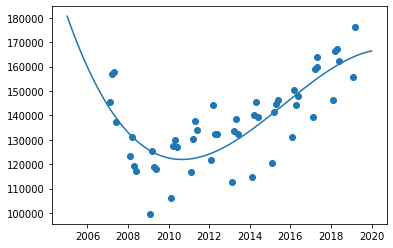

In [99]:
x= [float(x) for x in list(data.trimestre)]
y= [float(x) for x in list(data.total)]

mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))

myline = numpy.linspace(2005, 2020, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()